In [109]:
import SoapySDR
import pycuda
import numpy as np
import pylab
from SoapySDR import * #SOAPY_SDR_ constants


In [122]:
# %run hellosdr.py
def collect_data(fc = 104.0e6, fs=5e6, nsamples=100, packet_size = 1024):

    #enumerate devices
    # results = SoapySDR.Device.enumerate()
    # for result in results: print(result)

    #create device instance
    #args can be user defined or from the enumeration result
    args = dict(driver="lime")
    sdr = SoapySDR.Device(args)

    #query device info
    print(sdr.listAntennas(SOAPY_SDR_RX, 0))
    print(sdr.listGains(SOAPY_SDR_RX, 0))
    freqs = sdr.getFrequencyRange(SOAPY_SDR_RX, 0)
    for freqRange in freqs: print(freqRange)

    # #apply settings
    # sdr.setSampleRate(SOAPY_SDR_RX, 0, 5e6)
    # sdr.setFrequency(SOAPY_SDR_RX, 0, 912.3e6)

    # #setup a stream (complex floats)
    # rxStream = sdr.setupStream(SOAPY_SDR_RX, SOAPY_SDR_CF32)
    # sdr.activateStream(rxStream) #start streaming

    bandwidth = fs

    sdr.setAntenna(SOAPY_SDR_RX, 0, 'LNAL')
    sdr.setFrequency(SOAPY_SDR_RX, 0, fc)
    sdr.setSampleRate(SOAPY_SDR_RX, 0, fs)
    sdr.setBandwidth(SOAPY_SDR_RX, 0, bandwidth)
    sdr.setDCOffsetMode(SOAPY_SDR_RX, 0, True)

    if sdr.hasGainMode(SOAPY_SDR_RX, 0):
        sdr.setGainMode(SOAPY_SDR_RX, 0, False)

    gains = {"LNA": 20, "TIA": 0, "PGA": -12}
    for gain, value in gains.items():
        sdr.setGain(SOAPY_SDR_RX, 0, gain, value)

    rx_stream = sdr.setupStream(SOAPY_SDR_RX, SOAPY_SDR_CF32)#SOAPY_SDR_CS16)
    sdr.activateStream(rx_stream)


    #create a re-usable buffer for rx samples
    # buff = numpy.array([0]*1024, numpy.complex64)
    

    rx_buff = np.empty(shape=(nsamples, packet_size), dtype=np.complex64)

    timestamps = []
    #receive some samples
    for i in range(nsamples):
        sr = sdr.readStream(rx_stream, [rx_buff[i]], packet_size)
        if sr.ret != packet_size:
            print(sr.ret)
            print('Bad samples from remote!')
        # print("Samples", sr.ret) #num samples or error code
        # print(sr.flags) #flags set by receive operation
#         print("Timestamp: %f ns" % sr.timeNs) #timestamp for receive buffer
        timestamps.append(sr.timeNs)
    #shutdown the stream
    sdr.deactivateStream(rx_stream) #stop streaming
    sdr.closeStream(rx_stream)
    print("Done")
    return rx_buff.ravel(), timestamps

In [146]:

nsamp = 10000
sample_rate = 50.0e6
frequency = 100.0e6

iq_array, timestamps = collect_data(fc = frequency, fs=sample_rate, nsamples=nsamp, packet_size = 1024)

('NONE', 'LNAH', 'LNAL', 'LNAW', 'LB1', 'LB2')
('TIA', 'LNA', 'PGA')
0, 3.8e+09
Done


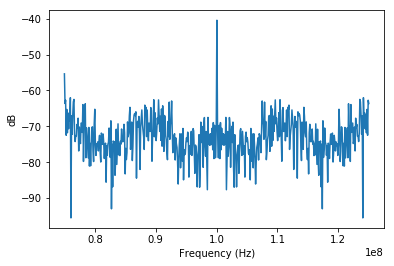

In [151]:
import matplotlib.pyplot as plt


#Convert to Numpy array
# iq_array = np.fromstring(iq, dtype = np_data_type)
#Get Power (Power = I^2 + Q^2)
all_i = iq_array.real ** 2 # iq_array[::2] ** 2
all_q = iq_array.imag ** 2 #iq_array[1::2] ** 2
pwr_array = np.add(all_i, all_q)
#Take FFT
fft_bins = 512
fft_array = np.fft.fft(pwr_array, fft_bins)
#Shift FFT
fft_array = np.fft.fftshift(fft_array)
db_array = 20*np.log10(abs(fft_array))
#Fill the x axis with correct frequency values
x_vals = np.linspace(frequency - sample_rate/2.0, frequency + sample_rate /2.0, num=fft_bins)
#Plot dB values
plt.plot(x_vals, db_array)
#Label axes
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
#plt.ylim(min(db_array), max(db_array))

plt.show()

/home/mdj/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


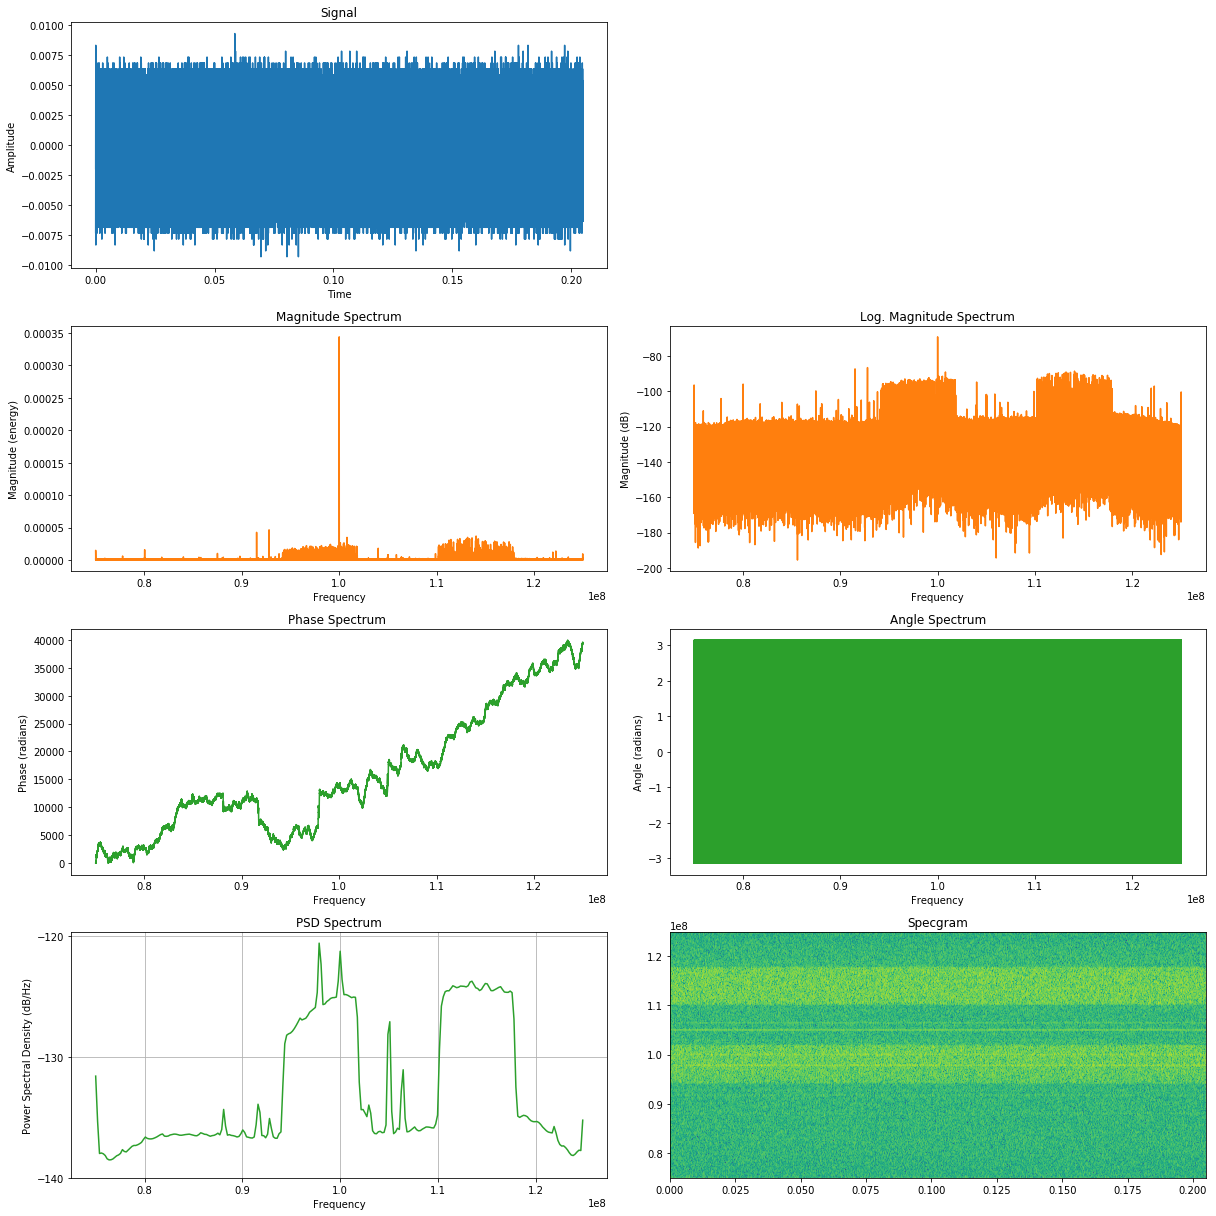

In [148]:
import matplotlib.pyplot as plt
import numpy as np


# np.random.seed(0)

# dt = 0.01  # sampling interval
# Fs = 1 / dt  # sampling frequency
# t = np.arange(0, 10, dt)

# # generate noise:
# nse = np.random.randn(len(t))
# r = np.exp(-t / 0.05)
# cnse = np.convolve(nse, r) * dt
# cnse = cnse[:len(t)]

# s = 0.1 * np.sin(4 * np.pi * t) + cnse  # the signal

s = iq_array #np.absolute(iq_array)
Fs = sample_rate
dt = 1 / Fs
t = np.arange(0, len(s) * dt, dt)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(17, 17))

# plot time signal:
axes[0, 0].set_title("Signal")
axes[0, 0].plot(t, s, color='C0')
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Amplitude")

# plot different spectrum types:
axes[1, 0].set_title("Magnitude Spectrum")
axes[1, 0].magnitude_spectrum(s, Fs=Fs, Fc=frequency, color='C1')

axes[1, 1].set_title("Log. Magnitude Spectrum")
axes[1, 1].magnitude_spectrum(s, Fs=Fs, Fc=frequency, scale='dB', color='C1')

axes[2, 0].set_title("Phase Spectrum ")
axes[2, 0].phase_spectrum(s, Fs=Fs, Fc=frequency, color='C2')

axes[2, 1].set_title("Angle Spectrum")
axes[2, 1].angle_spectrum(s, Fs=Fs, Fc=frequency, color='C2')

axes[3, 0].set_title("PSD Spectrum")
axes[3, 0].psd(s, Fs=Fs, Fc=frequency, color='C2')

axes[3, 1].set_title("Specgram")
axes[3, 1].specgram(s, Fs=Fs, Fc=frequency)

axes[0, 1].remove()  # don't display empty ax

fig.tight_layout()
plt.show()